In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import time
from datetime import datetime

from fastai.vision.all import *
import pyautogui
import pygetwindow as gw
import keyboard
import numpy as np
import cv2

from selenium import webdriver
from selenium.webdriver.chrome.options import Options

In [3]:
# need to declare globally cuz to override label_func
path = 'dataset'
fnames = get_image_files(path)
def label_func(x): return x.parent.name

def load_model(path):    
    learn = load_learner(os.path.abspath(path))
    return learn

In [4]:
def launch_chrome_dino():
    try:
        options = Options()
        options.add_argument("--window-size=800,800")
        driver = webdriver.Chrome(executable_path='./chromedriver', options=options)
        driver.get('chrome://dino')
    except Exception as e:
#         print(e)
        pass
    finally:
        print('Launching Dino.')
        
    screen_size = (pyautogui.size().width, pyautogui.size().height)
    dino_window = gw.getWindowsWithTitle('chrome://dino/ - Google Chrome')[0]
    
    window_size = 800
    dino_window.moveTo(screen_size[0]-window_size, 0)
    dino_window.resizeTo(window_size, window_size)
    
    return driver, dino_window, screen_size, window_size

In [5]:
def screenshot_frame(screen_size, window_size):
    # screenshot
    frame = pyautogui.screenshot(region=(screen_size[0]-window_size+7, 125, 350, 350))

    # change to grayscale
    frame = cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2GRAY)
    
    # resize to compatible with resnet model
    frame = cv2.resize(frame, (224,224))
    
    # convert to black n white to count white n black pixel
    # for checking black or white background
    thresh = 107
    sample_frame = cv2.threshold(frame, thresh, 255, cv2.THRESH_BINARY)[1]
    pixel_count = np.unique(sample_frame, return_counts=True)[1]
    
    if pixel_count[1] > pixel_count[0]:
        thresh = 190
        # actually change to black n white
        frame = cv2.threshold(frame, thresh, 255, cv2.THRESH_BINARY)[1]
        frame = np.invert(frame)
    else:
        thresh = 110
        frame = cv2.threshold(frame, thresh, 255, cv2.THRESH_BINARY)[1]
    
    return frame

In [6]:
learn = load_model('models/v5.pkl')

Launching Dino.


IndexError: index 1 is out of bounds for axis 0 with size 1

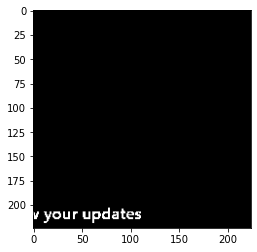

In [23]:
_, dino_window, screen_size, window_size = launch_chrome_dino()

#start the game
pyautogui.press('up')

time.sleep(20)

while True:
    frame = screenshot_frame(screen_size, window_size)
    hotkey = learn.predict(frame)[0]
    
    if hotkey == 'up':
        pyautogui.press('up')
    elif hotkey == 'down':
        pyautogui.press('down')

    if keyboard.is_pressed('esc'):
        break
